In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Libraries and Filesystem Setup

In [2]:
import pandas as pd
import pickle
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

### Import LDA document vectors

In [26]:
LDA = pickle.load(open("../processing_files/LDA_mat.pickle", "rb"))
df_merged = pickle.load(open("../processing_files/df_merged.pickle", "rb"))

In [27]:
df_merged.head()

,DOMAIN,RAW_CONTENT
0,0-my.com,0-my.com related searches: related searches:
1,00bitz.com,error. page cannot be displayed. please contac...
2,01187.com,01187.com is available for purchase! - wwwv1.c...
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons..."
4,03h.org,february | 2014 | online marketing review sear...


In [28]:
df_merged.shape

(12946, 2)

In [29]:
LDA.shape

(12946, 10)

## knn

In [30]:
%%time
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(LDA)
distances, indices = nbrs.kneighbors(LDA)

CPU times: user 1.23 s, sys: 16.3 ms, total: 1.25 s
Wall time: 1.24 s


In [31]:
print(distances.shape)
print(indices.shape)

(12946, 20)
(12946, 20)


In [32]:
distances[0]

array([0.00000000e+00, 0.00000000e+00, 5.49332006e-06, 6.44819277e-06,
       6.44819277e-06, 6.44819277e-06, 6.44819277e-06, 6.44819277e-06,
       9.13094149e-06, 1.60232812e-05, 1.65687608e-05, 1.99037298e-05,
       2.24156130e-05, 2.27568900e-05, 2.27568900e-05, 2.25270427e-02,
       2.25648566e-02, 2.25661610e-02, 2.25661610e-02, 2.25661610e-02])

In [33]:
indices[0]

array([    0,   160,  7652,   533, 12267,  4751,  5445,  4911, 11647,
        8949,  8907,  9901,  8556, 12763, 12927,  4445,   278,  1623,
        3125,   111])

In [34]:
import statistics

def intracluster_similarity(index):
    cluster_centroid = LDA[index]
    sum_dist = 0
    dist_list = []
    for i in indices[index][1:]:
        distance = np.linalg.norm(cluster_centroid-LDA[i])
        sum_dist += distance
        dist_list.append(distance)
        #print(index, ',', i, '=', distance)
        
    avg = sum_dist/(len(indices[index])-1)
    #print('average:', avg)
    
    variance = statistics.variance(dist_list)
    #print('variance:', variance)
    
    return avg, variance

In [35]:
intracluster_similarity(0)

(0.005945140667545328, 0.0001040438225676554)

In [36]:
def generate_raw_content_cluster_df(index):
    index_list = list(indices[index])
    distance_list = list(distances[index])
    cluster_seed = df_merged.loc[index].to_frame().T
    cluster_seed['DISTANCE'] = 0
    cluster_df = df_merged.loc[index_list[1:]]
    cluster_df['DISTANCE'] = distance_list[1:]
    combined = pd.concat([cluster_seed, cluster_df.sort_values(by='DISTANCE', ascending=True)])
    return combined.style.set_properties(subset=['RAW_CONTENT'], **{'width-min': '100px'})
    #return combined

In [39]:
# non-unique index errors
# 14 is a good example
# 21 can we stop output after distance goes from 3 to 10.583?
# 22 is lots of similar basic e
generate_raw_content_cluster_df(2)

,DOMAIN,RAW_CONTENT,DISTANCE
2,01187.com,"01187.com is available for purchase! - wwwv1.com welcome to uunic.com,these domain names are for sale,feel free to contact us! filter by suffix on sale $22600 01187.com 01187.com this domain is of unlimited value. this domain is for sale - $22600 usd! inquery this domain : reach agreementreasonable price start transactionfair and safe payment sentdomain transfered both confirmedtransaction closed make offer online domain: your name: offer price: usd sorry,your offer is too low,we will never consider e-mail: inquiry: enteraccess code: * send recommended payment method easy,big amount,low fees! my bank information intermediary bank: china merchants bank co. ltd., new york. bank swift code：cmbcus33 beneficiary’s bank: china merchants bank, h.o. bank address：cmb tower,7088 shennan boulevard, shenzhen, china. bank swift code：cmbccnbs my bank account name： my bank account number： my phone number: (+86)400-601-5335 domain: your name: domain transfer by:godaddy pushauthorization code domain price: usd paypal fees: buyer pay50% eachseller pay payment detail: paypal fees:,buyer pay:,total: usd e-mail: message: newbie why buy? contact us | | © 2005-2014 wwwv1.com all rights reserved.",0
2433,coastaldcc.co.uk,"coastal dcc - dcc by modellers for modellers 01473 710946your basket is empty coastal dcc by modellersfor modellerstoggle navigation featured products out of stock our price: £185.00 add to basket in stock our price: £14.59 add to basket in stock our price: £180.00 add to basket in stock our price: £17.50 add to basket in stock our price: £20.00 add to basket coastal dcc is run by railway modellers for railway modellers we are dedicated to giving you the railway modeller the very best dcc advice. we aim to supply you with the best digital command control equipment to suit your unique needs tweets by @coastaldcc payment methods: coastal dcc ltdregistered offices: 71 alan road, ipswich ip3 8eyregistration number: 9447637 in england & wales | | | |",0.0892039
2980,dbsltd.org.uk,"dbs ltd products archive - page 2 of 3 - dbs ltd search for: email: sales@dbsltd.org.uk call: 01793 533511 shop showing 9–16 of 17 results sort by popularity sort by newness sort by price: low to high sort by price: high to low 2 shop categories shopping cart > products dbs ltd unit 4, star west westmead trading estate swindon sn5 7sw services specialist sectors call us now on 01793 533511 or email us at sales@dbsltd.org.uk this website uses cookies to improve your experience. we'll assume you're ok with this, but you can opt-out if you wish. privacy & cookies policy",0.0938852
8206,newtechfeed.com,"newtech market – newtechfeed submit close search submit search viral, hot and clever we sell trending tech & gadgets. hot right now our best collections follow our instagram page | 70k! instagram @newtechfeed lighters reusable charging cable 160 reviews regular price $41.24 sale price $23.99 sale hot plasma lighter 51 reviews regular price $42.00 sale price $24.99 sale smart bracelet no reviews regular price $29.00 sale price $29.00 sale ear pods 56 reviews regular price $129.99 sale price $39.95 sale payment methods american express apple pay mastercard paypal visa © 2020,",0.107024
10327,smart-gsm.net,"activations - credits and activations - flash and unlock, manufacturer brand: asansam, price: usd 0.00 - usd 99.99 - smart-gsm.net all categories cell spare parts flash and unlock free shipping mobile phone accessories uncategorized all categories products(show all) categories articles(show all) your shopping cart is empty | category top brands top products regular price: usd 159.00 special price usd 155.00 regular price: usd 115.00 special price usd 109.99 usd 167.00 top products regular price: usd 159.00 special price usd 155.00 regular price: usd 115.00 special price usd 109.99 usd 167.00 top brands search: we deliver worldwide *product replacement for warranty items that having problem in first 7 days. we deliver worldwi

In [15]:
avg_list = []
variance_list = []

for i in range(LDA.shape[0]):
    avg, variance = intracluster_similarity(i)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x1a17619828>,
 <a list of 11 Text xticklabel objects>)

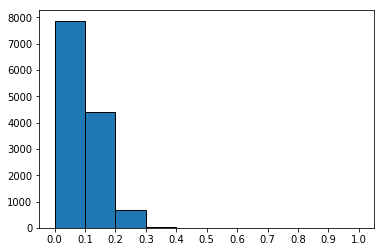

In [16]:
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x1a1c8b6320>,
 <a list of 11 Text xticklabel objects>)

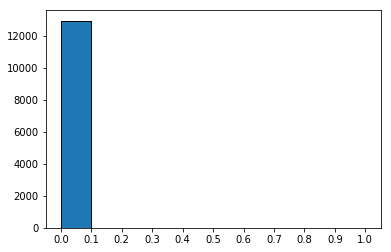

In [17]:
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

In [18]:
len(avg_list)

12949

In [19]:
len(variance_list)

12949

## Intercluster Similarity

In [20]:
#def intercluster_similarity(index):

In [21]:
def calculate_centroid(index):
    cluster_centroid = LDA[index]
    for i in indices[index][1:]:
        cluster_centroid = np.add(cluster_centroid, LDA[i])
    return cluster_centroid/len(indices[index][1:])

In [22]:
index_centroid = dict()
for i in range(LDA.shape[0]):
    index_centroid[i] = calculate_centroid(i)

In [23]:
index_centroid

{0: array([0.01126464, 0.01126416, 0.01126485, 0.0112643 , 0.63823291,
        0.01287158, 0.3201013 , 0.01126386, 0.0112638 , 0.01384018]),
 1: array([0.00957039, 0.00957008, 0.00957208, 0.00957005, 0.00957381,
        0.00957064, 0.96649268, 0.00957058, 0.00956976, 0.00957151]),
 2: array([0.00953608, 0.01579222, 0.36288218, 0.00514538, 0.1068966 ,
        0.0168436 , 0.02171235, 0.00514579, 0.00514583, 0.50353154]),
 3: array([0.01651437, 0.01807236, 0.38477321, 0.00654324, 0.13616319,
        0.00911606, 0.4034684 , 0.0041484 , 0.00762946, 0.06620289]),
 4: array([0.09020621, 0.00859163, 0.01377529, 0.20356091, 0.05405401,
        0.00867337, 0.02161971, 0.02376717, 0.01175959, 0.61662367]),
 5: array([0.00183973, 0.00183997, 0.48616952, 0.00183954, 0.00183986,
        0.00183952, 0.14254694, 0.00183964, 0.0023312 , 0.41054566]),
 6: array([0.00193027, 0.00193052, 0.48189374, 0.00193008, 0.00193041,
        0.00193006, 0.14644499, 0.00193019, 0.0019301 , 0.41078122]),
 7: array([0.

In [24]:
#centroid_centroid_distance = {}
#for i in range(LDA.shape[0]):
#    centroid_centroid_distance[i] = {}
#    for j in range(LDA.shape[0]):
#        if i < j:
#            centroid_centroid_distance[i][j] = np.linalg.norm(index_centroid[i]-index_centroid[j])

In [25]:
#centroid_centroid_distance